# Cross-Model Style Evaluation

This notebook evaluates reconstructions across different **model × prompting method** combinations.

## Methodology

Unlike the single-experiment evaluation in `style_evaluation.ipynb`, this notebook:

1. **Pulls reconstructions** from multiple existing evaluation databases
2. **Combines** them into unified comparison sets (e.g., Mistral+fewshot vs Kimi+fewshot vs Mistral+agent_holistic)
3. **Runs random 4-way comparisons**: For each sample, randomly sample 4 combinations and judge them
4. **Aggregates** using Bradley-Terry model to estimate strength of each combination

## Advantages over Pairwise ELO

- **More information per judgment**: 4-way ranking > pairwise comparison
- **Statistically principled**: Bradley-Terry gives confidence intervals and p-values
- **Efficient**: O(k*n) comparisons instead of O(n²) pairwise round-robin
- **Reuses existing infrastructure**: Same judge prompts and 4-way ranking code

## Prerequisites

You must have already run `style_evaluation.ipynb` with different reconstruction models to generate source databases.

## Setup

In [18]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

from belletrist import (
    LLM, LLMConfig, PromptMaker,
    CrossModelComparisonStore, Combination
)

## Configuration

### 1. Specify which combinations to compare

Each `Combination` specifies:
- `db_path`: Path to evaluation database
- `method`: Reconstruction method (e.g., 'fewshot', 'agent_holistic')
- `label`: Unique identifier for this combination (e.g., 'mistral_fewshot')
- `reconstruction_run`: Which run to use (default 0)

In [19]:
# Example: Compare fewshot and agent_holistic across two models
combinations = [
    # Mistral reconstructions
    Combination(
        db_path=Path("style_eval_s_mistral_r_mistral_j_anthropic.db"),
        method="fewshot",
        label="mistral_fewshot"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_mistral_j_anthropic.db"),
        method="agent_holistic",
        label="mistral_agent"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_mistral_j_anthropic.db"),
        method="author",
        label="mistral_author"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_mistral_j_anthropic.db"),
        method="generic",
        label="mistral_generic"
    ),
    
    # Kimi reconstructions
    Combination(
        db_path=Path("style_eval_s_mistral_r_kimi_j_anthropic.db"),
        method="fewshot",
        label="kimi_fewshot"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_kimi_j_anthropic.db"),
        method="agent_holistic",
        label="kimi_agent"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_kimi_j_anthropic.db"),
        method="author",
        label="kimi_author"
    ),
    Combination(
        db_path=Path("style_eval_s_mistral_r_kimi_j_anthropic.db"),
        method="generic",
        label="kimi_generic"
    ),
]

# Verify all databases exist
for combo in combinations:
    if not combo.db_path.exists():
        raise FileNotFoundError(f"Database not found: {combo.db_path}")

print(f"Configured {len(combinations)} combinations:")
for combo in combinations:
    print(f"  {combo.label:20s} = {combo.db_path.name} / {combo.method}")

Configured 8 combinations:
  mistral_fewshot      = style_eval_s_mistral_r_mistral_j_anthropic.db / fewshot
  mistral_agent        = style_eval_s_mistral_r_mistral_j_anthropic.db / agent_holistic
  mistral_author       = style_eval_s_mistral_r_mistral_j_anthropic.db / author
  mistral_generic      = style_eval_s_mistral_r_mistral_j_anthropic.db / generic
  kimi_fewshot         = style_eval_s_mistral_r_kimi_j_anthropic.db / fewshot
  kimi_agent           = style_eval_s_mistral_r_kimi_j_anthropic.db / agent_holistic
  kimi_author          = style_eval_s_mistral_r_kimi_j_anthropic.db / author
  kimi_generic         = style_eval_s_mistral_r_kimi_j_anthropic.db / generic


### 2. Configure judge LLM and comparison parameters

In [20]:
# Judge LLM configuration
JUDGE_MODEL = 'anthropic/claude-sonnet-4-5-20250929'
JUDGE_API_KEY_ENV_VAR = 'ANTHROPIC_API_KEY'
#JUDGE_MODEL = 'mistral/mistral-large-2512'
#JUDGE_API_KEY_ENV_VAR = 'MISTRAL_API_KEY'

# Comparison parameters
N_COMPARISONS_PER_SAMPLE = 6  # How many random 4-way comparisons per sample
RANDOM_SEED = 42  # For reproducibility

# Output database
OUTPUT_DB = Path(f"cross_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}.db")
#OUTPUT_DB = Path("cross_eval_20251215_110004.db")

print(f"Judge: {JUDGE_MODEL}")
print(f"Comparisons per sample: {N_COMPARISONS_PER_SAMPLE}")
print(f"Output: {OUTPUT_DB}")

Judge: anthropic/claude-sonnet-4-5-20250929
Comparisons per sample: 6
Output: cross_eval_20251215_180549.db


## Initialize Components

In [21]:
# Initialize judge LLM
judge_llm = LLM(LLMConfig(
    model=JUDGE_MODEL,
    api_key=os.environ.get(JUDGE_API_KEY_ENV_VAR)
))

# Initialize prompt maker
prompt_maker = PromptMaker()

# Initialize comparison store
comparer = CrossModelComparisonStore(
    output_db=OUTPUT_DB,
    combinations=combinations
)

print("✓ Components initialized")

✓ Components initialized


## Step 1: Load Reconstructions from Source Databases

Pull reconstructions from all configured databases. This verifies:
- All samples exist in all databases
- Original texts are consistent across databases
- Requested methods exist

In [22]:
# Load all samples (or specify sample_ids=['sample_000', 'sample_001', ...])
comparer.load_reconstructions()

# Check what was loaded
stats = comparer.get_stats()
print(f"\n=== Loaded Reconstructions ===")
print(f"Samples: {stats['n_samples']}")
print(f"Combinations: {stats['n_combinations']}")
print(f"Total reconstructions: {stats['n_samples'] * stats['n_combinations']}")

Loading all 10 samples from source databases

Loading from style_eval_s_mistral_r_mistral_j_anthropic.db:
  ✓ mistral_fewshot                - sample_000
  ✓ mistral_agent                  - sample_000
  ✓ mistral_author                 - sample_000
  ✓ mistral_generic                - sample_000
  ✓ mistral_fewshot                - sample_001
  ✓ mistral_agent                  - sample_001
  ✓ mistral_author                 - sample_001
  ✓ mistral_generic                - sample_001
  ✓ mistral_fewshot                - sample_002
  ✓ mistral_agent                  - sample_002
  ✓ mistral_author                 - sample_002
  ✓ mistral_generic                - sample_002
  ✓ mistral_fewshot                - sample_003
  ✓ mistral_agent                  - sample_003
  ✓ mistral_author                 - sample_003
  ✓ mistral_generic                - sample_003
  ✓ mistral_fewshot                - sample_004
  ✓ mistral_agent                  - sample_004
  ✓ mistral_author            

## Step 2: Run Random 4-Way Comparisons

For each sample, randomly sample `N_COMPARISONS_PER_SAMPLE` sets of 4 combinations and judge them.

This generates `n_samples × N_COMPARISONS_PER_SAMPLE` judgments total.

**Note:** This step calls the LLM judge and may take some time.

In [23]:
comparer.run_comparisons(
    judge_llm=judge_llm,
    prompt_maker=prompt_maker,
    n_comparisons_per_sample=N_COMPARISONS_PER_SAMPLE,
    seed=RANDOM_SEED
)

stats = comparer.get_stats()
print(f"\n=== Comparison Complete ===")
print(f"Total judgments: {stats['n_judgments']}")
print(f"Expected: {stats['n_samples'] * N_COMPARISONS_PER_SAMPLE}")

=== Running 6 comparisons × 10 samples = 60 total ===


sample_000:
  Comparison 0: Sampling 4 combinations... [mistral_author, kimi_agent, mistral_agent, mistral_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 1: Sampling 4 combinations... [kimi_fewshot, kimi_agent, kimi_author, mistral_agent]
    Judging... ✓ (confidence: high)
  Comparison 2: Sampling 4 combinations... [mistral_agent, mistral_fewshot, kimi_author, kimi_generic]
    Judging... ✓ (confidence: high)
  Comparison 3: Sampling 4 combinations... [kimi_author, kimi_agent, mistral_generic, kimi_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 4: Sampling 4 combinations... [kimi_fewshot, mistral_fewshot, kimi_author, mistral_agent]
    Judging... ✓ (confidence: high)
  Comparison 5: Sampling 4 combinations... [kimi_generic, mistral_fewshot, mistral_agent, mistral_author]
    Judging... ✓ (confidence: high)

sample_001:
  Comparison 0: Sampling 4 combinations... [kimi_fewshot, kimi_author, kimi_agent, mistra

    Judging... ✓ (confidence: high)
  Comparison 4: Sampling 4 combinations... [mistral_agent, mistral_author, mistral_generic, mistral_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 5: Sampling 4 combinations... [kimi_agent, mistral_agent, kimi_fewshot, mistral_fewshot]
    Judging... ✓ (confidence: high)

✓ Completed 60 total judgments

=== Comparison Complete ===
Total judgments: 60
Expected: 60


## Step 3: Export Results

In [24]:
# Export full judgment data
df_judgments = comparer.to_dataframe()

print(f"Total judgments: {len(df_judgments)}")
print(f"\n=== Sample Judgments ===")
display_cols = [
    'sample_id', 'comparison_run',
    'label_text_a', 'label_text_b', 'label_text_c', 'label_text_d',
    'ranking_text_a', 'ranking_text_b', 'ranking_text_c', 'ranking_text_d',
    'confidence'
]
print(df_judgments[display_cols].head(10))

# Save to CSV
output_csv = OUTPUT_DB.with_suffix('.csv')
df_judgments.to_csv(output_csv, index=False)
print(f"\n✓ Saved to {output_csv}")

Total judgments: 60

=== Sample Judgments ===
    sample_id  comparison_run     label_text_a     label_text_b  \
0  sample_000               0   mistral_author       kimi_agent   
1  sample_000               1     kimi_fewshot       kimi_agent   
2  sample_000               2    mistral_agent  mistral_fewshot   
3  sample_000               3      kimi_author       kimi_agent   
4  sample_000               4     kimi_fewshot  mistral_fewshot   
5  sample_000               5     kimi_generic  mistral_fewshot   
6  sample_001               0     kimi_fewshot      kimi_author   
7  sample_001               1    mistral_agent  mistral_generic   
8  sample_001               2  mistral_fewshot  mistral_generic   
9  sample_001               3  mistral_generic     kimi_generic   

      label_text_c     label_text_d  ranking_text_a  ranking_text_b  \
0    mistral_agent  mistral_fewshot               4               3   
1      kimi_author    mistral_agent               2               4   
2  

In [25]:
# Export Bradley-Terry format (pairwise preferences)
df_bt = comparer.to_bradley_terry_format()

print(f"\n=== Bradley-Terry Format ===")
print(f"Total pairwise preferences: {len(df_bt)}")
print(f"\nSample rows:")
print(df_bt.head(10))

# Save Bradley-Terry data
bt_csv = OUTPUT_DB.with_suffix('.bt.csv')
df_bt.to_csv(bt_csv, index=False)
print(f"\n✓ Saved to {bt_csv}")


=== Bradley-Terry Format ===
Total pairwise preferences: 360

Sample rows:
            winner            loser   sample_id  comparison_run
0       kimi_agent   mistral_author  sample_000               0
1    mistral_agent   mistral_author  sample_000               0
2  mistral_fewshot   mistral_author  sample_000               0
3    mistral_agent       kimi_agent  sample_000               0
4  mistral_fewshot       kimi_agent  sample_000               0
5    mistral_agent  mistral_fewshot  sample_000               0
6     kimi_fewshot       kimi_agent  sample_000               1
7      kimi_author     kimi_fewshot  sample_000               1
8     kimi_fewshot    mistral_agent  sample_000               1
9      kimi_author       kimi_agent  sample_000               1

✓ Saved to cross_eval_20251215_180549.bt.csv


## Step 4: Bradley-Terry Analysis

Fit a Bradley-Terry model to estimate the "strength" of each combination.

Bradley-Terry models pairwise preferences as:
$$P(i > j) = \frac{\pi_i}{\pi_i + \pi_j}$$

where $\pi_i$ is the strength parameter for combination $i$.

We'll use iterative maximum likelihood estimation (MM algorithm).

In [26]:
def fit_bradley_terry(df_pairs, max_iter=100, tol=1e-6):
    """
    Fit Bradley-Terry model using MM algorithm.
    
    Args:
        df_pairs: DataFrame with 'winner' and 'loser' columns
        max_iter: Maximum iterations
        tol: Convergence tolerance
    
    Returns:
        DataFrame with columns: label, strength, log_strength
    """
    # Count wins for each pair
    wins = df_pairs.groupby(['winner', 'loser']).size().reset_index(name='count')
    
    # Get all unique labels
    labels = sorted(set(df_pairs['winner']) | set(df_pairs['loser']))
    n = len(labels)
    label_to_idx = {label: i for i, label in enumerate(labels)}
    
    # Initialize strengths uniformly
    pi = np.ones(n)
    
    # Build win matrix W[i,j] = number of times i beat j
    W = np.zeros((n, n))
    for _, row in wins.iterrows():
        i = label_to_idx[row['winner']]
        j = label_to_idx[row['loser']]
        W[i, j] = row['count']
    
    # Total WINS by each item (not total comparisons!)
    total_wins = W.sum(axis=1)
    
    # Total comparisons involving each item (for reporting only)
    n_comparisons = W.sum(axis=1) + W.sum(axis=0)
    
    # MM algorithm
    for iteration in range(max_iter):
        pi_old = pi.copy()
        
        # Update each strength parameter
        for i in range(n):
            if n_comparisons[i] == 0:
                continue
            
            # Sum of 1/(pi_i + pi_j) over all j that i played against
            denom = 0
            for j in range(n):
                if i == j:
                    continue
                n_ij = W[i, j] + W[j, i]  # Total matches between i and j
                if n_ij > 0:
                    denom += n_ij / (pi_old[i] + pi_old[j])
            
            if denom > 0:
                pi[i] = total_wins[i] / denom  # FIX: Use total_wins, not n_comparisons
        
        # Normalize to prevent drift
        pi = pi / pi.sum() * n
        
        # Check convergence
        if np.max(np.abs(pi - pi_old)) < tol:
            print(f"Converged in {iteration + 1} iterations")
            break
    
    # Build results DataFrame
    results = pd.DataFrame({
        'label': labels,
        'strength': pi,
        'log_strength': np.log(pi),
        'n_comparisons': n_comparisons
    })
    
    return results.sort_values('strength', ascending=False).reset_index(drop=True)

# Fit model
bt_results = fit_bradley_terry(df_bt)

print("\n=== Bradley-Terry Rankings ===")
print(bt_results)

Converged in 57 iterations

=== Bradley-Terry Rankings ===
             label  strength  log_strength  n_comparisons
0  mistral_fewshot  2.342182      0.851083           99.0
1     kimi_fewshot  2.322844      0.842792           93.0
2     kimi_generic  1.912821      0.648579           75.0
3      kimi_author  0.752831     -0.283914          102.0
4    mistral_agent  0.322856     -1.130547           93.0
5       kimi_agent  0.143282     -1.942942           99.0
6  mistral_generic  0.103958     -2.263768           72.0
7   mistral_author  0.099225     -2.310370           87.0


## Step 5: Visualization

Visualize the Bradley-Terry strength estimates.

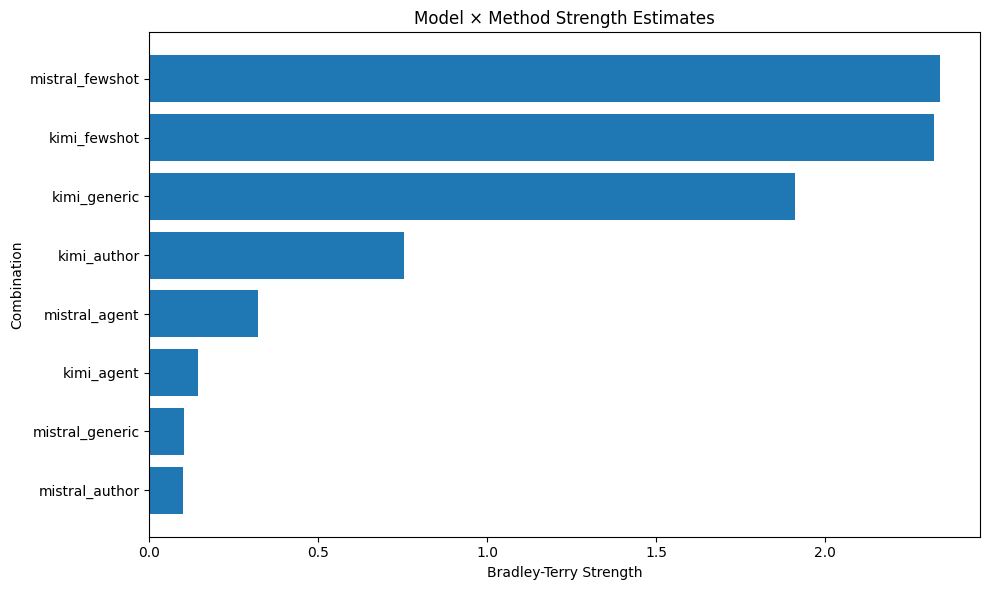

In [27]:
import matplotlib.pyplot as plt

# Bar chart of strengths
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(bt_results['label'], bt_results['strength'])
ax.set_xlabel('Bradley-Terry Strength')
ax.set_ylabel('Combination')
ax.set_title('Model × Method Strength Estimates')
ax.invert_yaxis()  # Best at top

plt.tight_layout()
plt.show()

## Step 6: Win Rate Matrix

Show pairwise win rates for interpretability.

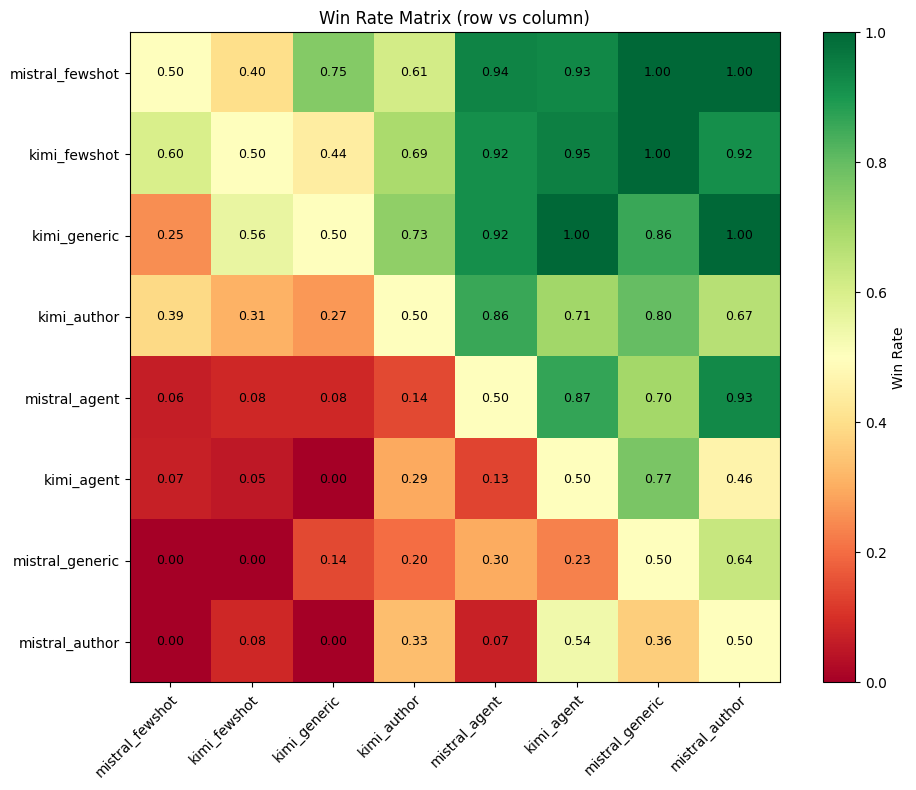


Interpretation: Cell (i, j) shows how often combination i beats combination j.
Green = high win rate, Red = low win rate


In [28]:
# Calculate win rate matrix
labels = bt_results['label'].tolist()
n = len(labels)

win_matrix = np.zeros((n, n))

for i, label_i in enumerate(labels):
    for j, label_j in enumerate(labels):
        if i == j:
            win_matrix[i, j] = 0.5  # Diagonal
            continue
        
        # Count wins
        wins_i = len(df_bt[(df_bt['winner'] == label_i) & (df_bt['loser'] == label_j)])
        wins_j = len(df_bt[(df_bt['winner'] == label_j) & (df_bt['loser'] == label_i)])
        total = wins_i + wins_j
        
        if total > 0:
            win_matrix[i, j] = wins_i / total
        else:
            win_matrix[i, j] = 0.5  # No data

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(win_matrix, cmap='RdYlGn', vmin=0, vmax=1)

# Labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f"{win_matrix[i, j]:.2f}",
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title("Win Rate Matrix (row vs column)")
fig.colorbar(im, ax=ax, label='Win Rate')
plt.tight_layout()
plt.show()

print("\nInterpretation: Cell (i, j) shows how often combination i beats combination j.")
print("Green = high win rate, Red = low win rate")

## Step 7: Statistical Summary

Compute additional statistics for each combination.

In [29]:
# Calculate statistics for each combination
stats_records = []

for label in labels:
    # Total wins and losses
    wins = len(df_bt[df_bt['winner'] == label])
    losses = len(df_bt[df_bt['loser'] == label])
    total = wins + losses
    
    # Win rate
    win_rate = wins / total if total > 0 else 0
    
    # Average rank (from original judgments)
    # Find all judgments involving this label
    ranks = []
    for _, row in df_judgments.iterrows():
        for letter in ['a', 'b', 'c', 'd']:
            if row[f'label_text_{letter}'] == label:
                ranks.append(row[f'ranking_text_{letter}'])
    
    avg_rank = np.mean(ranks) if ranks else np.nan
    
    # Get BT strength
    bt_strength = bt_results[bt_results['label'] == label]['strength'].values[0]
    
    stats_records.append({
        'label': label,
        'bt_strength': bt_strength,
        'win_rate': win_rate,
        'avg_rank': avg_rank,
        'total_wins': wins,
        'total_losses': losses,
        'n_judgments': len(ranks)
    })

df_stats = pd.DataFrame(stats_records).sort_values('bt_strength', ascending=False)

print("\n=== Comprehensive Statistics ===")
print(df_stats.to_string(index=False))

# Save stats
stats_csv = OUTPUT_DB.with_suffix('.stats.csv')
df_stats.to_csv(stats_csv, index=False)
print(f"\n✓ Saved to {stats_csv}")


=== Comprehensive Statistics ===
          label  bt_strength  win_rate  avg_rank  total_wins  total_losses  n_judgments
mistral_fewshot     2.342182  0.787879  1.636364          78            21           33
   kimi_fewshot     2.322844  0.795699  1.612903          74            19           31
   kimi_generic     1.912821  0.746667  1.760000          56            19           25
    kimi_author     0.752831  0.549020  2.352941          56            46           34
  mistral_agent     0.322856  0.408602  2.774194          38            55           31
     kimi_agent     0.143282  0.252525  3.242424          25            74           33
mistral_generic     0.103958  0.222222  3.333333          16            56           24
 mistral_author     0.099225  0.195402  3.413793          17            70           29

✓ Saved to cross_eval_20251215_180549.stats.csv


## Step 8. Inspection

In [30]:
# Inspect a specific judgment
INSPECT_SAMPLE = 'sample_000'
INSPECT_COMPARISON_RUN = 3

# Query judgment directly from database
judgment = comparer.conn.execute("""
    SELECT * FROM comparative_judgments
    WHERE sample_id=? AND comparison_run=?
""", (INSPECT_SAMPLE, INSPECT_COMPARISON_RUN)).fetchone()

if judgment:
    print(f"=== JUDGE REASONING: {INSPECT_SAMPLE}, Comparison {INSPECT_COMPARISON_RUN} ===\n")

    # Build mapping to show which label = which combination
    label_to_rank = {
        'A': judgment['ranking_text_a'],
        'B': judgment['ranking_text_b'],
        'C': judgment['ranking_text_c'],
        'D': judgment['ranking_text_d']
    }

    label_to_combo = {
        'A': judgment['label_text_a'],
        'B': judgment['label_text_b'],
        'C': judgment['label_text_c'],
        'D': judgment['label_text_d']
    }

    print("ANONYMOUS LABELS → COMBINATIONS:")
    for label in ['A', 'B', 'C', 'D']:
        combo = label_to_combo[label]
        rank = label_to_rank[label]
        print(f"  Text {label} = {combo:25s} → Rank {rank}")

    print(f"\nConfidence: {judgment['confidence']}")
    print(f"Judge Model: {judgment['judge_model']}")

    # Show reasoning
    print(f"\n{'REASONING':-^80}")
    print(judgment['reasoning'])
else:
    print(f"No judgment found for {INSPECT_SAMPLE}, comparison run {INSPECT_COMPARISON_RUN}")

=== JUDGE REASONING: sample_000, Comparison 3 ===

ANONYMOUS LABELS → COMBINATIONS:
  Text A = kimi_author               → Rank 2
  Text B = kimi_agent                → Rank 3
  Text C = mistral_generic           → Rank 4
  Text D = kimi_fewshot              → Rank 1

Confidence: high
Judge Model: claude-sonnet-4-5-20250929

-----------------------------------REASONING------------------------------------
Let me analyze each text's stylistic similarity to the original.

**Original's distinctive voice:**
The original has a clear, measured, professorial tone—direct yet sophisticated. It uses long sentences with careful logical structure, but maintains clarity through straightforward vocabulary. The author addresses the reader conversationally ("I do not mean," "What I do mean"), establishes positions methodically, and uses practical examples without excessive ornamentation. There's a quality of patient explanation, building arguments brick by brick. The prose is serious but not pompous, i

In [31]:
# View the 4 reconstructions that were compared
INSPECT_SAMPLE = 'sample_000'
INSPECT_COMPARISON_RUN = 3

# Get the judgment to see which labels were compared
judgment = comparer.conn.execute("""
    SELECT * FROM comparative_judgments
    WHERE sample_id=? AND comparison_run=?
""", (INSPECT_SAMPLE, INSPECT_COMPARISON_RUN)).fetchone()

if judgment:
    
    print(f"=== RECONSTRUCTIONS FOR {INSPECT_SAMPLE}, Comparison {INSPECT_COMPARISON_RUN} ===\n")

    # Get labels that were compared
    labels_compared = [
        judgment['label_text_a'],
        judgment['label_text_b'],
        judgment['label_text_c'],
        judgment['label_text_d']
    ]

    # Get original text (same for all)
    original = comparer.get_reconstruction(INSPECT_SAMPLE, labels_compared[0])

    print(f"{'ORIGINAL':-^80}")
    print(original['original_text'])
    print("\n\n")

    # Show each reconstruction
    for letter, label in zip(['A', 'B', 'C', 'D'], labels_compared):
        rec = comparer.get_reconstruction(INSPECT_SAMPLE, label)
        rank_col = f'ranking_text_{letter.lower()}'
        rank = judgment[rank_col]

        print(f"{label.upper()} - {label} (Rank {rank})"+ "-" * (80 - len(label) - 15))
        print(rec['reconstructed_text'])
        print(f"\n({len(rec['reconstructed_text'])} chars, model: {rec['reconstruction_model']})\n")


=== RECONSTRUCTIONS FOR sample_000, Comparison 3 ===

------------------------------------ORIGINAL------------------------------------
In reading even the best treatises on education written in former
times, one becomes aware of certain changes that have come over
educational theory. The two great reformers of educational theory
before the nineteenth century were Locke and Rousseau. Both deserved
their reputation, for both repudiated many errors which were
wide-spread when they wrote. But neither went as far in his own
direction as almost all modern educationists go. Both, for example,
belong to the tendency which led to liberalism and democracy; yet
both consider only the education of an aristocratic boy, to which one
man’s whole time is devoted. However excellent might be the results
of such a system, no man with a modern outlook would give it serious
consideration, because it is arithmetically impossible for every child
to absorb the whole time of an adult tutor. The system is there

## Summary

**Interpretation Guide:**

- **Bradley-Terry Strength**: Higher = better. Represents estimated "ability" to beat other combinations
- **Win Rate**: Proportion of pairwise comparisons won (should correlate with BT strength)
- **Average Rank**: Lower = better (1 = best, 4 = worst in each 4-way comparison)

**Next Steps:**

1. Compare BT rankings to simple average rank to validate model fit
2. Examine judge reasoning for close competitors
3. Bootstrap confidence intervals for BT strengths
4. Run additional comparisons if rankings are unstable